In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import select_coint_rank, coint_johansen
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.filters.hp_filter import hpfilter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

In [391]:
slv = pd.read_csv(f"data/SLV-Prices.csv")
gld = pd.read_csv(f"data/GLD-Prices.csv")

cpi = pd.read_csv(f"data/CPI.csv")
gdp = pd.read_csv(f"data/GDP.csv")
yields = pd.read_csv(f"data/YIELDS.csv")


gdp.rename(columns={'observation_date': 'Date'}, inplace=True)
cpi.rename(columns={'MEDCPIM158SFRBCLE': 'CPI', 'observation_date': 'Date'}, inplace=True)
yields.rename(columns={'IRLTLT01USM156N': 'Yields', 'observation_date': 'Date'}, inplace=True)


gdp['Date'] = pd.to_datetime(gdp['Date'])
cpi['Date'] = pd.to_datetime(cpi['Date'])
yields['Date'] = pd.to_datetime(yields['Date'])

slv['Date'] = pd.to_datetime(slv['Date'])
gld['Date'] = pd.to_datetime(gld['Date'])

In [392]:
yields.set_index('Date', inplace=True)
yields.index = pd.to_datetime(yields.index)
full_range_yields = pd.date_range(start=yields.index.min(), end=yields.index.max(), freq='D')
yields_daily = yields.reindex(full_range_yields)
yields_daily = yields_daily.apply(pd.to_numeric, errors='coerce')
yields_daily = yields_daily.interpolate(method='time')
yields_daily.index.name = 'Date'

In [393]:
gdp.set_index('Date', inplace=True)
gdp.index = pd.to_datetime(gdp.index)
full_range = pd.date_range(start=gdp.index.min(), end=gdp.index.max(), freq='D')
gdp_daily = gdp.reindex(full_range)
gdp_daily = gdp_daily.apply(pd.to_numeric, errors='coerce')
gdp_daily = gdp_daily.interpolate(method='time')
gdp_daily.index.name = 'Date'

In [394]:
cpi.set_index('Date', inplace=True)
cpi.index = pd.to_datetime(cpi.index)
full_range = pd.date_range(start=cpi.index.min(), end=cpi.index.max(), freq='D')
cpi_daily = cpi.reindex(full_range)
cpi_daily = cpi_daily.apply(pd.to_numeric, errors='coerce')
cpi_daily = cpi_daily.interpolate(method='time')
cpi_daily.index.name = 'Date'

In [396]:
slv = slv.set_index('Date').resample('D').ffill()
gld = gld.set_index('Date').resample('D').ffill()
slv = slv.reset_index()

gld = gld.reset_index()

In [397]:
gdp = gdp_daily
cpi = cpi_daily
yields = yields_daily

In [398]:
gdp = gdp.reset_index()

cpi = cpi.reset_index()

yields = yields.reset_index()

In [399]:
start_date, end_date = '2021-12-25', '2024-10-01'
slv = slv[(slv['Date'] >= start_date) & (slv['Date'] <= end_date)].reset_index(drop=True)
gld = gld[(gld['Date'] >= start_date) & (gld['Date'] <= end_date)].reset_index(drop=True)

yields = yields[(yields['Date'] >= start_date) & (yields['Date'] <= end_date)].reset_index(drop=True)
cpi = cpi[(cpi['Date'] >= start_date) & (cpi['Date'] <= end_date)].reset_index(drop=True)
gdp = gdp[(gdp['Date'] >= start_date) & (gdp['Date'] <= end_date)].reset_index(drop=True)                                      

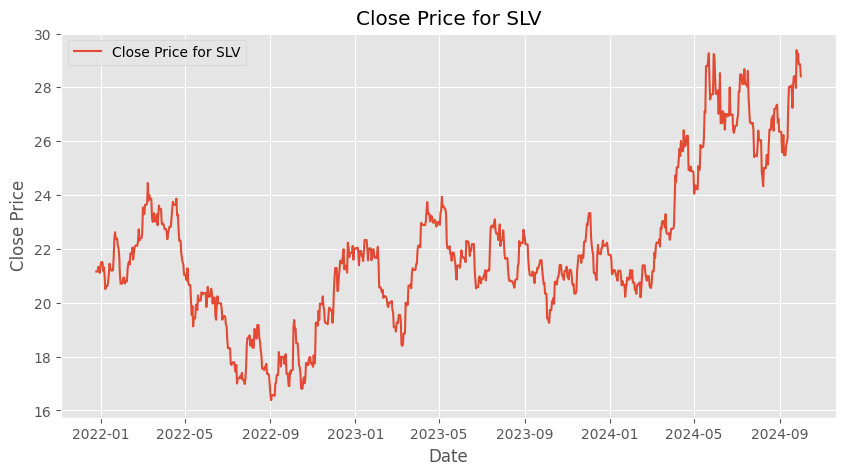

In [400]:
plt.figure(figsize=(10, 5)) 
plt.plot(slv['Date'], slv['Close'], label='Close Price for SLV') 
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Close Price for SLV") 
plt.grid(True) 
plt.legend() 
plt.show() 

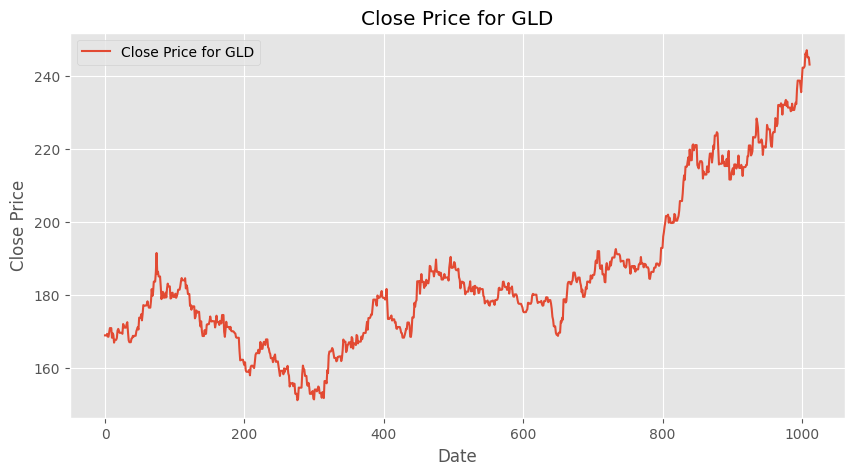

In [401]:
plt.figure(figsize=(10, 5))  
plt.plot(gld.index, gld['Close'], label='Close Price for GLD')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Close Price for GLD") 
plt.grid(True) 
plt.legend() 
plt.show()  

In [402]:
def detrend_hf(series, lamb):
    cycle, trend = hpfilter(series, lamb)
    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Original Series')
    plt.plot(trend, label='Trend Component')
    plt.plot(cycle, label='Detrended Series (Cyclical Component)')
    plt.legend()
    plt.title('Detrending Using HP Filter')
    plt.show()
    return cycle
    
    

## Joining multiple df's into one

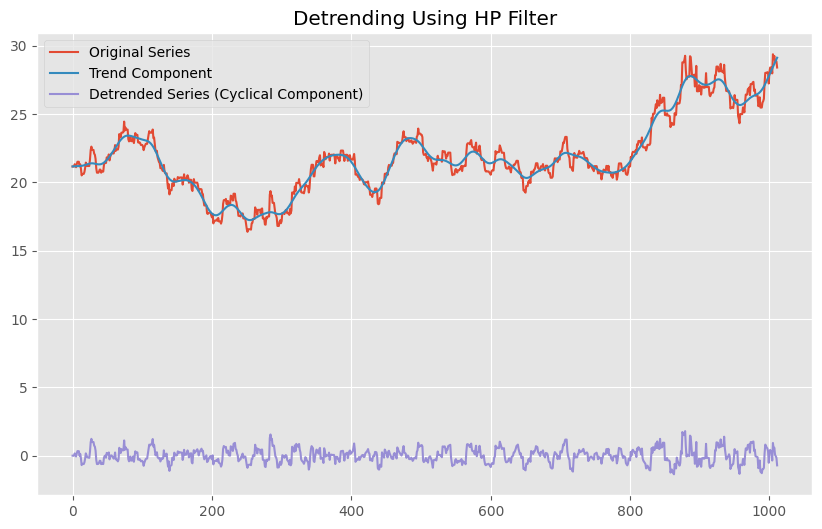

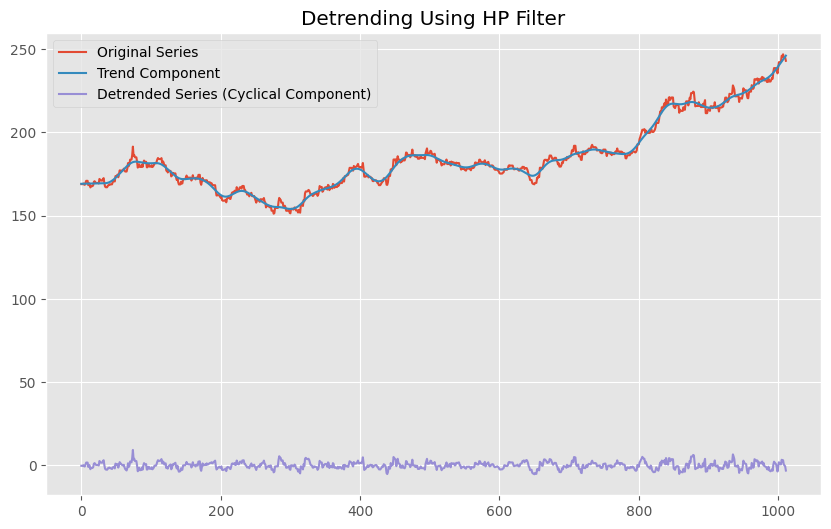

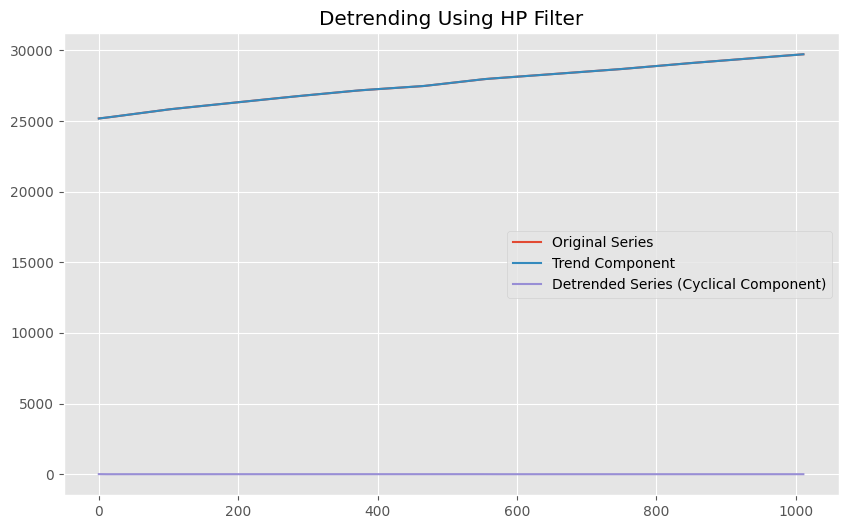

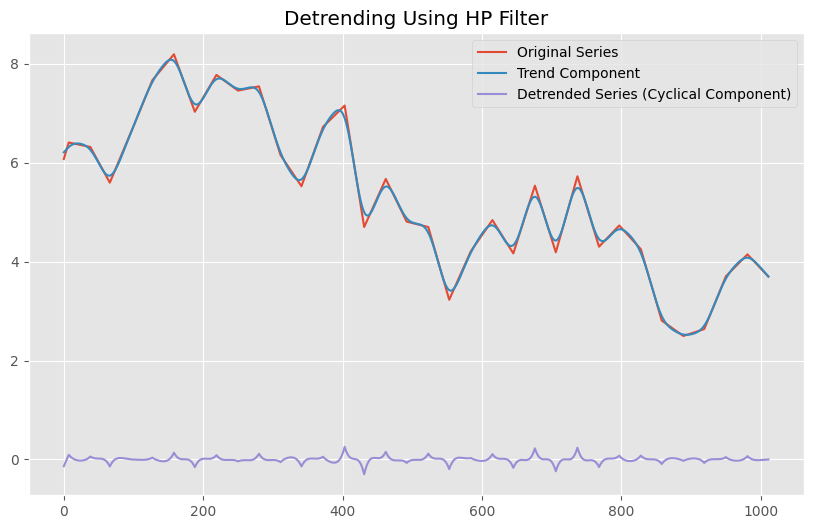

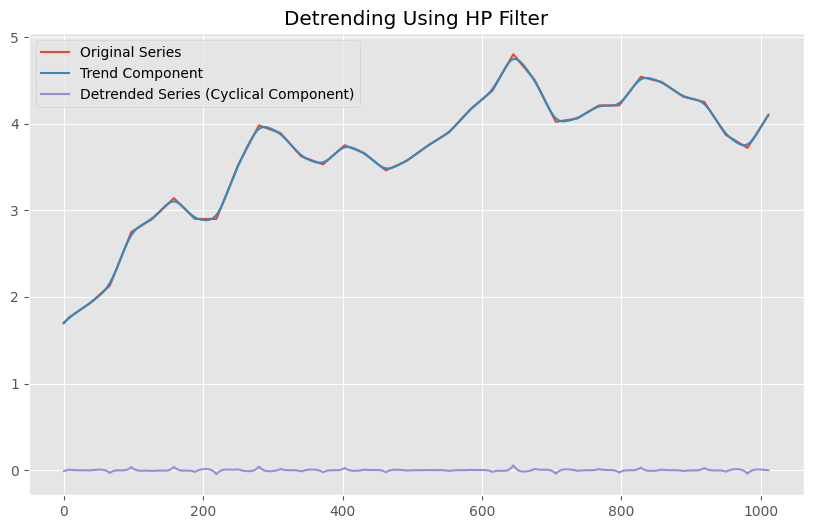

In [403]:
data_hp = pd.DataFrame({'SLV': detrend_hf(slv["Close"], 4000), 'GLD': detrend_hf(gld["Close"], 4000), 'GDP': detrend_hf(gdp["GDP"], 2000), 'CPI': detrend_hf(cpi["CPI"], 2000), 'Yields': detrend_hf(yields["Yields"], 2000)})

In [404]:
def perform_stationarity_tests(series, signif=0.05, verbose=False):
    """
    Performs both ADF and KPSS tests on the given series.
    """
    results = {}

    # Augmented Dickey-Fuller Test
    try:
        adf_test = adfuller(series, autolag='AIC')
        adf_stat = adf_test[0]
        adf_pvalue = adf_test[1]
        results['ADF'] = {'Test Statistic': adf_stat, 'p-value': adf_pvalue}
        if verbose:
            print('ADF Test:')
            print(f"Test Statistic: {adf_stat}, p-value: {adf_pvalue}")
    except Exception as e:
        results['ADF'] = None

    # KPSS Test
    try:
        kpss_test = kpss(series, regression='c', nlags='auto')
        kpss_stat = kpss_test[0]
        kpss_pvalue = kpss_test[1]
        results['KPSS'] = {'Test Statistic': kpss_stat, 'p-value': kpss_pvalue}
        if verbose:
            print('KPSS Test:')
            print(f"Test Statistic: {kpss_stat}, p-value: {kpss_pvalue}")
    except Exception as e:
        results['KPSS'] = None

    return results


def determine_optimal_differencing(series, max_d=2, signif=0.05, verbose=False):
    """
    Determines the optimal differencing order 'd' for the series.
    """
    for d in range(max_d + 1):
        if d == 0:
            differenced_series = series.copy()
        else:
            differenced_series = series.diff(d).dropna()
        test_results = perform_stationarity_tests(
            differenced_series, signif=signif, verbose=verbose)
        adf_pvalue = test_results['ADF']['p-value'] if test_results['ADF'] else None
        kpss_pvalue = test_results['KPSS']['p-value'] if test_results['KPSS'] else None

        adf_stationary = adf_pvalue is not None and adf_pvalue < signif
        kpss_stationary = kpss_pvalue is not None and kpss_pvalue >= signif

        if verbose:
            print(
                f"Differencing order d={d}: ADF stationary={adf_stationary}, KPSS stationary={kpss_stationary}")

        if adf_stationary and kpss_stationary:
            if verbose:
                print(f"Optimal differencing order determined: d={d}")
            return d

    if verbose:
        print(
            f"No optimal differencing order found up to d={max_d}. Using d={max_d}")
    return max_d

# Both Commodities Differencing
Since both tests agree for both commodities in their original form SLV and GLD are non stationary however at the first difference level they become stationary series. This means they are integrated at a property of 1.

In [405]:
def johansen_test(series, model_type=0, det_order=1, verbose=True):
    """
    Performs the Johansen cointegration test and explains the results.
    
    Parameters:
    -----------
    series : pd.DataFrame
        A multivariate time series (each column is a variable).
    model_type : int
        Deterministic term:
            0: no deterministic terms,
            1: constant term,
            2: linear trend,
            3: quadratic trend,
            4: constant + linear trend.
    det_order : int
        The lagged difference order (usually 1).
    verbose : bool
        If True, prints detailed explanations of the results.
        
    Returns:
    --------
    dict
        A dictionary containing eigenvalues, trace statistics, max eigenvalue statistics,
        and their critical values.
    """
    try:
        j_test = coint_johansen(series, model_type, det_order)
        r = 0
        for stat, crit in zip(j_test.lr1, j_test.cvt):
            if stat > crit[1]:  # Compare to 95% critical value
                r += 1
        results = {
            'Eigenvalues': j_test.eig,
            'Trace Statistics': j_test.lr1,
            'Trace Critical Values': j_test.cvt,
            'Max Eigenvalue Statistics': j_test.lr2,
            'Max Eigen Critical Values': j_test.cvm,
            'Cointegration Rank' : r
        }

        if verbose:
            print("\n--- Johansen Cointegration Test Results ---")
            print("\nEigenvalues:")
            print(j_test.eig)
            
            print("\nTrace Statistics and Critical Values:")
            for i, stat in enumerate(j_test.lr1):
                print(f"  H₀: At most {i} cointegration relations")
                print(f"    Trace Statistic = {stat:.4f}")
                print(f"    Critical Values (90%, 95%, 99%) = {j_test.cvt[i]}")
                if stat > j_test.cvt[i][1]:
                    print("    → Reject H₀ at 5% level: Evidence of cointegration")
                else:
                    print("    → Fail to reject H₀ at 5% level: No strong evidence")
            
            print("\nMax Eigenvalue Statistics and Critical Values:")
            for i, stat in enumerate(j_test.lr2):
                print(f"  H₀: At most {i} cointegration relations")
                print(f"    Max-Eigen Statistic = {stat:.4f}")
                print(f"    Critical Values (90%, 95%, 99%) = {j_test.cvm[i]}")
                if stat > j_test.cvm[i][1]:
                    print("    → Reject H₀ at 5% level: Evidence of cointegration")
                else:
                    print("    → Fail to reject H₀ at 5% level: No strong evidence")

        return results

    except Exception as e:
        print("Error performing Johansen test:", e)
        return None


In [406]:
from statsmodels.tsa.vector_ar.var_model import VAR

def select_optimal_lag(data, maxlags=15):
    model = VAR(data)
    results = model.select_order(maxlags=maxlags)
    return {
        'AIC': results.aic,
        'BIC': results.bic,
        'HQIC': results.hqic
    }

In [435]:
from statsmodels.tsa.vector_ar.vecm import VECM

def fit_vecm_model(data, coint_rank, lag_order, exog=None, deterministic = "ci"):
    """
    Fits a VECM model with optional exogenous variables.
    
    Parameters:
    - data: DataFrame or array-like
        Endogenous variables (e.g., SLV and GLD prices).
    - coint_rank: int
        Cointegration rank (from Johansen test).
    - lag_order: int
        Number of lags for the VAR part (e.g., 1 or 2).
    - exog: DataFrame or array-like (optional)
        Exogenous variables (e.g., differenced CPI).
        
    Returns:
    - Fitted VECM model results.
    """
    model = VECM(
        endog=data,
        exog=exog,  # Pass exogenous variables here
        k_ar_diff=1,
        coint_rank=1,
        deterministic=deterministic # "ci" = constant in coint. eq., "li" = linear trend
    )
    vecm_res = model.fit()
    return vecm_res

## Running Tests on data

In [408]:
print(f"\n GDP Stationarity Testing:")
d = determine_optimal_differencing(gdp['GDP'], verbose=True)

print(f"\n CPI Stationarity Testing:")
d = determine_optimal_differencing(cpi['CPI'], verbose=True)

print(f"\n Yields Stationarity Testing:")
d = determine_optimal_differencing(yields['Yields'], verbose=True)


 GDP Stationarity Testing:
ADF Test:
Test Statistic: -2.440155725595708, p-value: 0.13072192613677075
KPSS Test:
Test Statistic: 5.129065727740005, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -2.166957611478416, p-value: 0.21845569582391272
KPSS Test:
Test Statistic: 2.422009854391292, p-value: 0.01
Differencing order d=1: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -2.71833491015388, p-value: 0.07091891159138534
KPSS Test:
Test Statistic: 2.421268141305388, p-value: 0.01
Differencing order d=2: ADF stationary=False, KPSS stationary=False
No optimal differencing order found up to d=2. Using d=2

 CPI Stationarity Testing:
ADF Test:
Test Statistic: -2.2041450480812994, p-value: 0.20474448474819396
KPSS Test:
Test Statistic: 3.913449151769806, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -4.98415406855339, p-value: 2.3852796414296776e-0

In [409]:
print(f"\n SLV Stationarity Testing:")
close_series = slv['Close']
d = determine_optimal_differencing(close_series, verbose=True)

print(f"\n GLD Stationarity Testing:")
close_series = gld['Close']
d = determine_optimal_differencing(close_series, verbose=True)


 SLV Stationarity Testing:
ADF Test:
Test Statistic: -0.77996435469178, p-value: 0.8249366621399161
KPSS Test:
Test Statistic: 2.5010072970344344, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -7.880446242675757, p-value: 4.718456888416329e-12
KPSS Test:
Test Statistic: 0.11265114273176068, p-value: 0.1
Differencing order d=1: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=1

 GLD Stationarity Testing:
ADF Test:
Test Statistic: 0.9479770633971637, p-value: 0.9936855595000667
KPSS Test:
Test Statistic: 3.6413482883796195, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -24.470111087588847, p-value: 0.0
KPSS Test:
Test Statistic: 0.3491424363195055, p-value: 0.09907653606917867
Differencing order d=1: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=1


## Analyzing results

Since the results of the stationary tests and differencing tests show that GDP and Yields are I(2) it is best practice to exclude them from the cointegration space. However since CPI is I(1) it will turn to I(0) in the VECM so it is safe to include as a exogenous variable in the VECM. GLD and SLV are I(1) and are stationary so it is fine to use them in a VECM

In [424]:
exog = cpi["CPI"].diff().dropna().values.reshape(-1, 1)

In [425]:
endog = pd.DataFrame({'SLV': slv['Close'], 'GLD': gld['Close']})

In [426]:
endog = endog.iloc[1:]

In [427]:
johansen = johansen_test(endog, model_type=0, det_order=best_lag-1, verbose=True)


--- Johansen Cointegration Test Results ---

Eigenvalues:
[0.00987432 0.00792137]

Trace Statistics and Critical Values:
  H₀: At most 0 cointegration relations
    Trace Statistic = 18.0551
    Critical Values (90%, 95%, 99%) = [13.4294 15.4943 19.9349]
    → Reject H₀ at 5% level: Evidence of cointegration
  H₀: At most 1 cointegration relations
    Trace Statistic = 8.0324
    Critical Values (90%, 95%, 99%) = [2.7055 3.8415 6.6349]
    → Reject H₀ at 5% level: Evidence of cointegration

Max Eigenvalue Statistics and Critical Values:
  H₀: At most 0 cointegration relations
    Max-Eigen Statistic = 10.0226
    Critical Values (90%, 95%, 99%) = [12.2971 14.2639 18.52  ]
    → Fail to reject H₀ at 5% level: No strong evidence
  H₀: At most 1 cointegration relations
    Max-Eigen Statistic = 8.0324
    Critical Values (90%, 95%, 99%) = [2.7055 3.8415 6.6349]
    → Reject H₀ at 5% level: Evidence of cointegration


### Analyzing the Results of the Johansen test

When performing the Johanssen test on the non HP filtered data we only find 2 cointegrating relationships, this means I can use a VECM with a coint_rank of 2

In [428]:
rank = johansen["Cointegration Rank"]
rank

2

In [436]:
vecm_res = fit_vecm_model(endog, coint_rank=1, lag_order=1, exog=exog, deterministic='ci')

In [437]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
exog1,0.3071,0.322,0.953,0.341,-0.325,0.939
L1.SLV,0.0131,0.053,0.248,0.804,-0.090,0.117
L1.GLD,-0.0097,0.012,-0.777,0.437,-0.034,0.015
,coef,std err,z,P>|z|,[0.025,0.975]
exog1,2.1730,1.364,1.593,0.111,-0.500,4.846
L1.SLV,-0.0547,0.223,-0.245,0.806,-0.493,0.383
L1.GLD,-0.0161,0.053,-0.304,0.761,-0.120,0.087
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0278,0.009,-2.942,0.003,-0.046,-0.009
,coef,std err,z,P>|z|,[0.025,0.975]


In [444]:
vecm_res2 = fit_vecm_model(endog, coint_rank=1, lag_order=0, exog=None, deterministic='none')

In [445]:
vecm_res2.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.SLV,0.0099,0.053,0.188,0.851,-0.093,0.113
L1.GLD,-0.0089,0.012,-0.712,0.477,-0.033,0.016
,coef,std err,z,P>|z|,[0.025,0.975]
L1.SLV,-0.0757,0.223,-0.339,0.735,-0.514,0.362
L1.GLD,-0.0107,0.053,-0.203,0.839,-0.114,0.093
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0252,0.009,-2.722,0.006,-0.043,-0.007
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0446,0.039,-1.139,0.255,-0.121,0.032
,coef,std err,z,P>|z|,[0.025,0.975]


## VECM Results

The results show a cointegration vector of SLV = 0.1150 * GLD + 0.6577

The negative coefficient for GLD beta.2 = -0.115 means that for every 1 increase in GLD, SLV tends to decrease by 0.115 this is when we have a constant term including the CPI. This also implies that GLD is a core driver of the relationship between the two commodities.

However, when you do not include the constant term you get a vector that looks like SLV = 0.1179*GLD

## SLV in coint 1 and GLD in coint 2

So we need to manually estimate the cointegration relationship between GLD and SLV using the Engle-Granger method

<Axes: title={'center': 'Cointegration Spread: SLV - 0.1179*GLD'}>

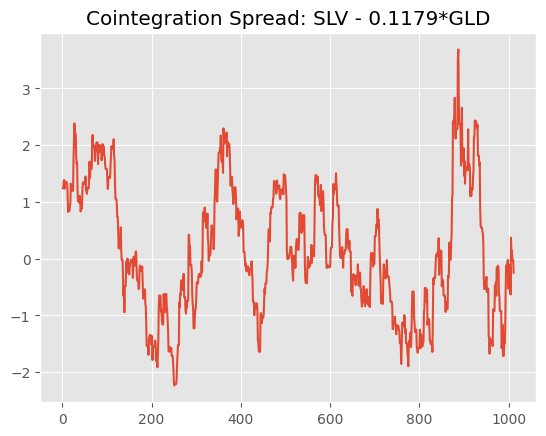

In [440]:
spread = endog["SLV"] - 0.1179 * endog["GLD"]
spread.plot(title="Cointegration Spread: SLV - 0.1179*GLD")

### The spread looks and is mean reverting

## Old code where macro economic data is exogeous

In [103]:
macro_cycles = pd.DataFrame({'GDP': gdp_filled['GDP'], 'CPI': cpi_filled['CPI'], "Yields" : yields_filled['Yields']})

In [104]:
macro_cycles.head()

,GDP,CPI,Yields
0,0.007107,0.006352,0.000003
1,0.010386,0.007028,0.000004
2,0.013661,0.007700,0.000006
3,0.016921,0.008359,0.000007
4,0.020145,0.008993,0.000009


In [139]:
slv_gld_merged.head()

,SLV,GLD,GDP,CPI,Yields
Date,,,,,
2022-01-01,0.390781,1.385798,0.007107,0.006352,0.000003
2022-01-02,0.387839,1.426724,0.010386,0.007028,0.000004
2022-01-03,0.384653,1.466784,0.013661,0.007700,0.000006
2022-01-04,0.050736,-1.125781,0.016921,0.008359,0.000007
2022-01-05,0.185362,0.146357,0.020145,0.008993,0.000009


In [106]:
print("Number of NaNs in macro_cycles:", np.isnan(macro_cycles).sum())
print("Number of infs in macro_cycles:", np.isinf(macro_cycles).sum())

macro_cycles_cleaned = macro_cycles.replace([np.inf, -np.inf], np.nan).ffill()

# Check again for NaNs and infs
print("Number of NaNs after cleaning:", np.isnan(macro_cycles_cleaned).sum())
print("Number of infs after cleaning:", np.isinf(macro_cycles_cleaned).sum())


Number of NaNs in macro_cycles: GDP       0
CPI       0
Yields    0
dtype: int64
Number of infs in macro_cycles: GDP       0
CPI       0
Yields    0
dtype: int64
Number of NaNs after cleaning: GDP       0
CPI       0
Yields    0
dtype: int64
Number of infs after cleaning: GDP       0
CPI       0
Yields    0
dtype: int64


In [107]:
macro_cycles_cleaned.shape

(1005, 3)

In [140]:
slv_gld_merged.shape

(1005, 5)

In [109]:
slv_gld_merged_aligned = slv_gld_merged.loc[macro_cycles_cleaned.index]

In [110]:
coint = select_coint_rank(slv_gld_merged_aligned, -1,0)
coint.rank
coint.summary()

r_0,r_1,test statistic,critical value
0,2,302.0,12.32
1,2,129.9,4.130


In [141]:
from statsmodels.tsa.vector_ar.vecm import VECM
model = VECM(slv_gld_merged, k_ar_diff=0, coint_rank=2)
result = model.fit()
residuals = result.resid


print(result.summary())

                Loading coefficients (alpha) for equation SLV                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.0700      0.012      5.998      0.000       0.047       0.093
ec2           -0.0444      0.007     -6.286      0.000      -0.058      -0.031
                Loading coefficients (alpha) for equation GLD                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.4979      0.047     10.489      0.000       0.405       0.591
ec2           -0.3189      0.029    -11.101      0.000      -0.375      -0.263
                Loading coefficients (alpha) for equation GDP                 
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [142]:
perform_stationarity_tests(residuals[:, 0], verbose=True)

ADF Test:
Test Statistic: -11.850364606940543, p-value: 7.232663863223894e-22
KPSS Test:
Test Statistic: 0.005855876625749164, p-value: 0.1


{'ADF': {'Test Statistic': -11.850364606940543,
  'p-value': 7.232663863223894e-22},
 'KPSS': {'Test Statistic': 0.005855876625749164, 'p-value': 0.1}}

## Results are stationary

Since the residuals are stationary which confirms that the original time seriers are cointegrated and that there is a long-term equilibrium betwen the series and deviations from the equilibrium are temporary and revert back to the mean

In [155]:
beta=result.beta
alpha = result.alpha

spread1 = np.dot(slv_gld_merged, beta[:, 0])
spread2 = np.dot(slv_gld_merged, beta[:, 1])


# 2 spreads since 2 cointegrated relationships

In [157]:
spreads_df = pd.DataFrame({'spread1': spread1,'spread2': spread2 }, index=slv_gld_merged.index)

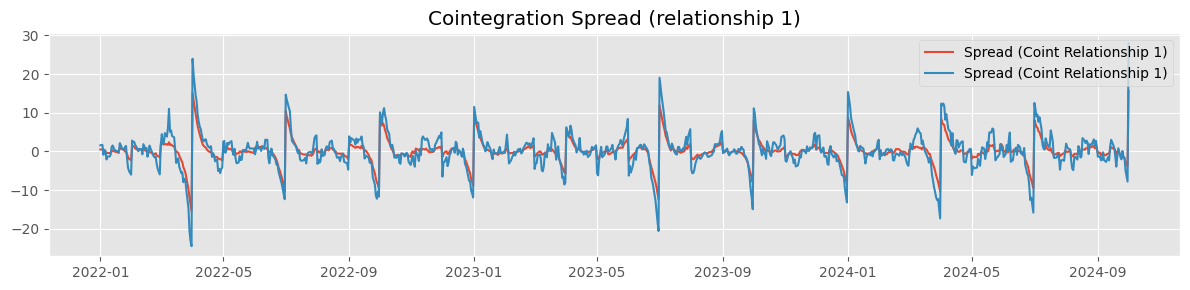

In [158]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(spreads_df.index, spreads_df['spread1'], label='Spread (Coint Relationship 1)')
plt.title('Cointegration Spread (relationship 1)')
plt.legend()


plt.subplot(3, 1, 1)
plt.plot(spreads_df.index, spreads_df['spread2'], label='Spread (Coint Relationship 1)')
plt.title('Cointegration Spread (relationship 1)')
plt.legend()



plt.tight_layout()
plt.show()

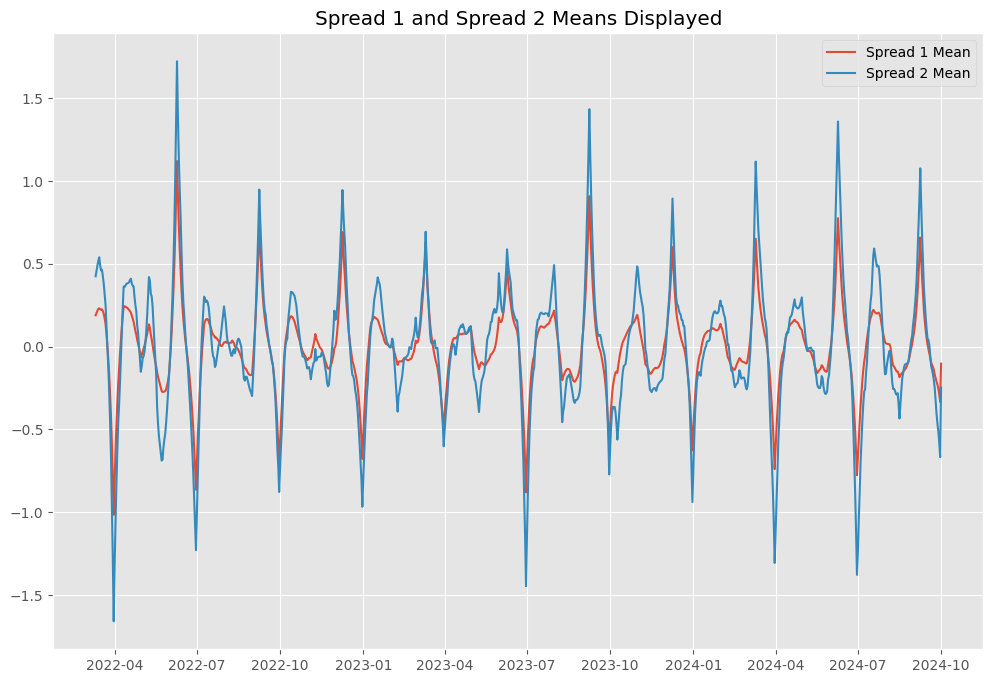

Cointegration Relationship 1: Gold adjusts 87.67%, Silver adjusts 12.33%
Cointegration Relationship 2: Gold adjusts 87.77%, Silver adjusts 12.23%


In [159]:
# Calculate z-scores for standardization
window = 70
gold_col = 1  # Adjust based on the column index of gold in your data
silver_col = 0  # Adjust based on the column index of silver in your data

spreads_df['spread1_mean'] = spreads_df['spread1'].rolling(window=window).mean()
spreads_df['spread1_std'] = spreads_df['spread1'].rolling(window=window).std()
spreads_df['z_score1'] = (spreads_df['spread1'] - spreads_df['spread1_mean']) / spreads_df['spread1_std']

spreads_df['spread2_mean'] = spreads_df['spread2'].rolling(window=window).mean()
spreads_df['spread2_std'] = spreads_df['spread2'].rolling(window=window).std()
spreads_df['z_score2'] = (spreads_df['spread2'] - spreads_df['spread2_mean']) / spreads_df['spread2_std']


gold_adjustment_speed1 = abs(alpha[gold_col, 0])
gold_adjustment_speed2 = abs(alpha[gold_col, 1])
silver_adjustment_speed1 = abs(alpha[silver_col, 0])
silver_adjustment_speed2 = abs(alpha[silver_col, 1])
adjustment_ratio1 = gold_adjustment_speed1 / (gold_adjustment_speed1 + silver_adjustment_speed1)
adjustment_ratio2 = gold_adjustment_speed2 / (gold_adjustment_speed2 + silver_adjustment_speed2)

plt.figure(figsize=(12, 8))
plt.plot(spreads_df.index, spreads_df['spread1_mean'], label='Spread 1 Mean')
plt.plot(spreads_df.index, spreads_df['spread2_mean'], label='Spread 2 Mean')

plt.title('Spread 1 and Spread 2 Means Displayed')
plt.legend()
plt.show()



print(f"Cointegration Relationship 1: Gold adjusts {adjustment_ratio1:.2%}, Silver adjusts {1-adjustment_ratio1:.2%}")
print(f"Cointegration Relationship 2: Gold adjusts {adjustment_ratio2:.2%}, Silver adjusts {1-adjustment_ratio2:.2%}")

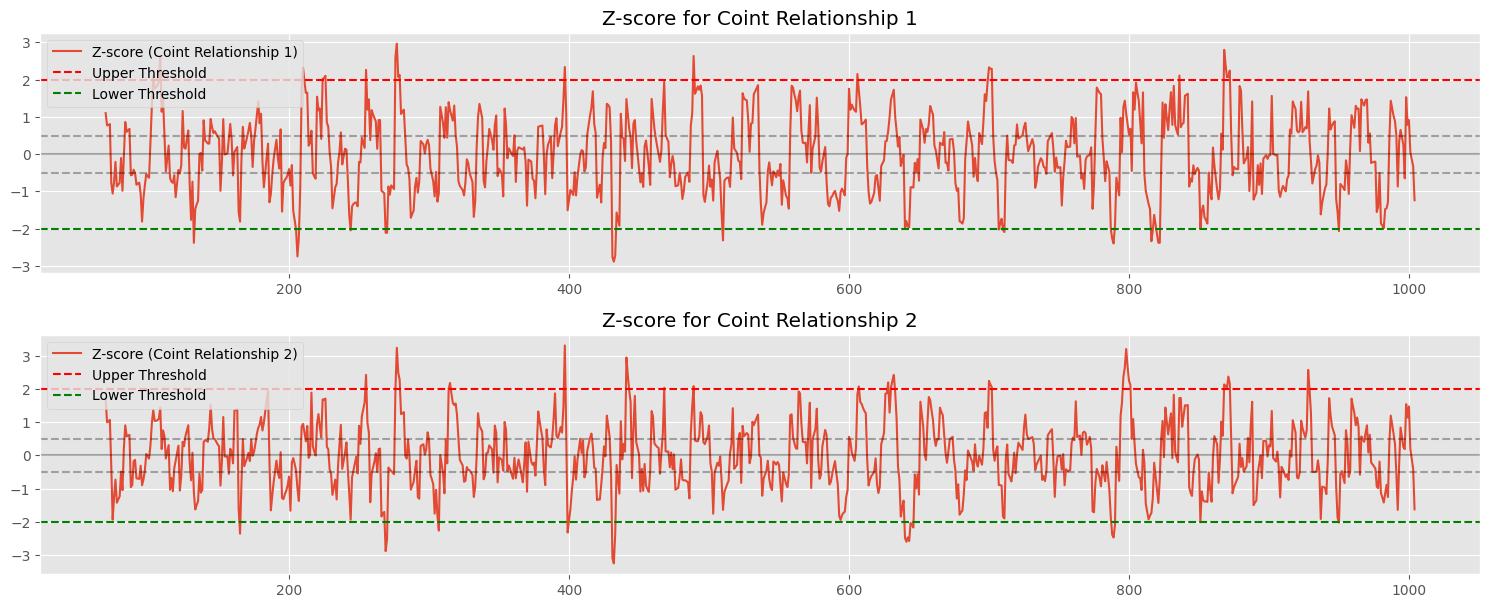

In [118]:
# Plot 1: Z-scores for first cointegration relationship

entry_threshold = 2
exit_threshold = 0.5

plt.figure(figsize=(15, 15))
plt.subplot(5, 1, 1)
plt.plot(spreads_df.index, spreads_df['z_score1'], label='Z-score (Coint Relationship 1)')
plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-entry_threshold, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.title(f'Z-score for Coint Relationship 1')
plt.legend()

# Plot 2: Z-scores for second cointegration relationship
plt.subplot(5, 1, 2)
plt.plot(spreads_df.index, spreads_df['z_score2'], label='Z-score (Coint Relationship 2)')
plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-entry_threshold, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.title(f'Z-score for Coint Relationship 2')
plt.legend()


plt.tight_layout()
plt.show()

In [160]:

# Generate trading signals based on z-scores
# We'll focus on the first cointegrating relationship for this example
spreads_df['signal'] = 0  # Initialize signals
# Signal 1: Buy gold, sell silver
spreads_df.loc[spreads_df['z_score1'] < -2, 'signal'] = 1
# Signal -1: Sell gold, buy silver
spreads_df.loc[spreads_df['z_score1'] > 2, 'signal'] = -1
# Close position when z-score is between -0.5 and 0.5
spreads_df.loc[(spreads_df['z_score1'] > -0.5) & (spreads_df['z_score1'] < 0.5), 'signal'] = 0

# Calculate position changes (entry/exit points)
spreads_df['position_change'] = spreads_df['signal'].diff()

# Implement a simple backtesting framework
# Extract gold and silver price columns
gold_col = 0  # Adjust based on the column index of gold in your data
silver_col = 1  # Adjust based on the column index of silver in your data

gold_prices = slv_gld_merged_aligned.iloc[:, gold_col]
silver_prices = slv_gld_merged_aligned.iloc[:, silver_col]

# Create a DataFrame to track our portfolio
portfolio = pd.DataFrame(index=spreads_df.index)
portfolio['gold_position'] = 0
portfolio['silver_position'] = 0
portfolio['cash'] = 10000  # Starting with $10,000

# Fill in the initial NaN values in spreads_df
spreads_df = spreads_df.fillna(0)

# Implement trading logic
for i in range(1, len(spreads_df)):
    # Get previous positions
    prev_gold_pos = portfolio.loc[portfolio.index[i-1], 'gold_position']
    prev_silver_pos = portfolio.loc[portfolio.index[i-1], 'silver_position']
    prev_cash = portfolio.loc[portfolio.index[i-1], 'cash']
    
    # Get current prices
    gold_price = gold_prices.iloc[i]
    silver_price = silver_prices.iloc[i]
    
    # Get current signal
    current_signal = spreads_df.loc[spreads_df.index[i], 'signal']
    
    # Set position sizing (adjust as needed)
    position_size = 1000  # Dollar amount per trade
    
    # Update positions based on signals
    if current_signal == 1 and prev_gold_pos == 0:  # Buy gold, sell silver
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = -silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        
    elif current_signal == -1 and prev_gold_pos == 0:  # Sell gold, buy silver
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = -gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        
    elif current_signal == 0 and (prev_gold_pos != 0 or prev_silver_pos != 0):  # Close positions
        # Calculate PnL
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = 0
        portfolio.loc[portfolio.index[i], 'silver_position'] = 0
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl
        
    else:  # Maintain positions
        # Update positions to account for price changes
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = prev_gold_pos
        portfolio.loc[portfolio.index[i], 'silver_position'] = prev_silver_pos
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl

# Calculate portfolio value
portfolio['gold_value'] = portfolio['gold_position'] * gold_prices
portfolio['silver_value'] = portfolio['silver_position'] * silver_prices
portfolio['total_value'] = portfolio['gold_value'] + portfolio['silver_value'] + portfolio['cash']

# Calculate returns
portfolio['returns'] = portfolio['total_value'].pct_change()
portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() - 1

# Visualize results
plt.figure(figsize=(12, 8))

# Plot 1: Z-scores and trading signals
plt.subplot(3, 1, 1)
plt.plot(spreads_df.index, spreads_df['z_score1'], label='Z-score (Coint Relationship 1)')
plt.axhline(y=2, color='r', linestyle='--', label='Upper Threshold (2)')
plt.axhline(y=-2, color='g', linestyle='--', label='Lower Threshold (-2)')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-0.5, color='k', linestyle='--', alpha=0.3)
plt.scatter(spreads_df.index[spreads_df['signal'] == 1], 
            [-2.5] * sum(spreads_df['signal'] == 1), 
            marker='^', color='g', s=50, label='Buy Gold Signal')
plt.scatter(spreads_df.index[spreads_df['signal'] == -1], 
            [2.5] * sum(spreads_df['signal'] == -1), 
            marker='v', color='r', s=50, label='Sell Gold Signal')
plt.title('Z-score and Trading Signals')
plt.legend()

# Plot 2: The spread
plt.subplot(3, 1, 2)
plt.plot(spreads_df.index, spreads_df['spread1'], label='Spread (Coint Relationship 1)')
plt.title('Cointegration Spread')
plt.legend()

# Plot 3: Cumulative returns
plt.subplot(3, 1, 3)
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Strategy Returns')
plt.title('Cumulative Returns')
plt.legend()

plt.tight_layout()
plt.show()

# Performance metrics
annualized_return = portfolio['returns'].mean() * 252  # Assuming 252 trading days
annualized_vol = portfolio['returns'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else 0
max_drawdown = (portfolio['total_value'] / portfolio['total_value'].cummax() - 1).min()

print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")

NameError: name 'slv_gld_merged_aligned' is not defined

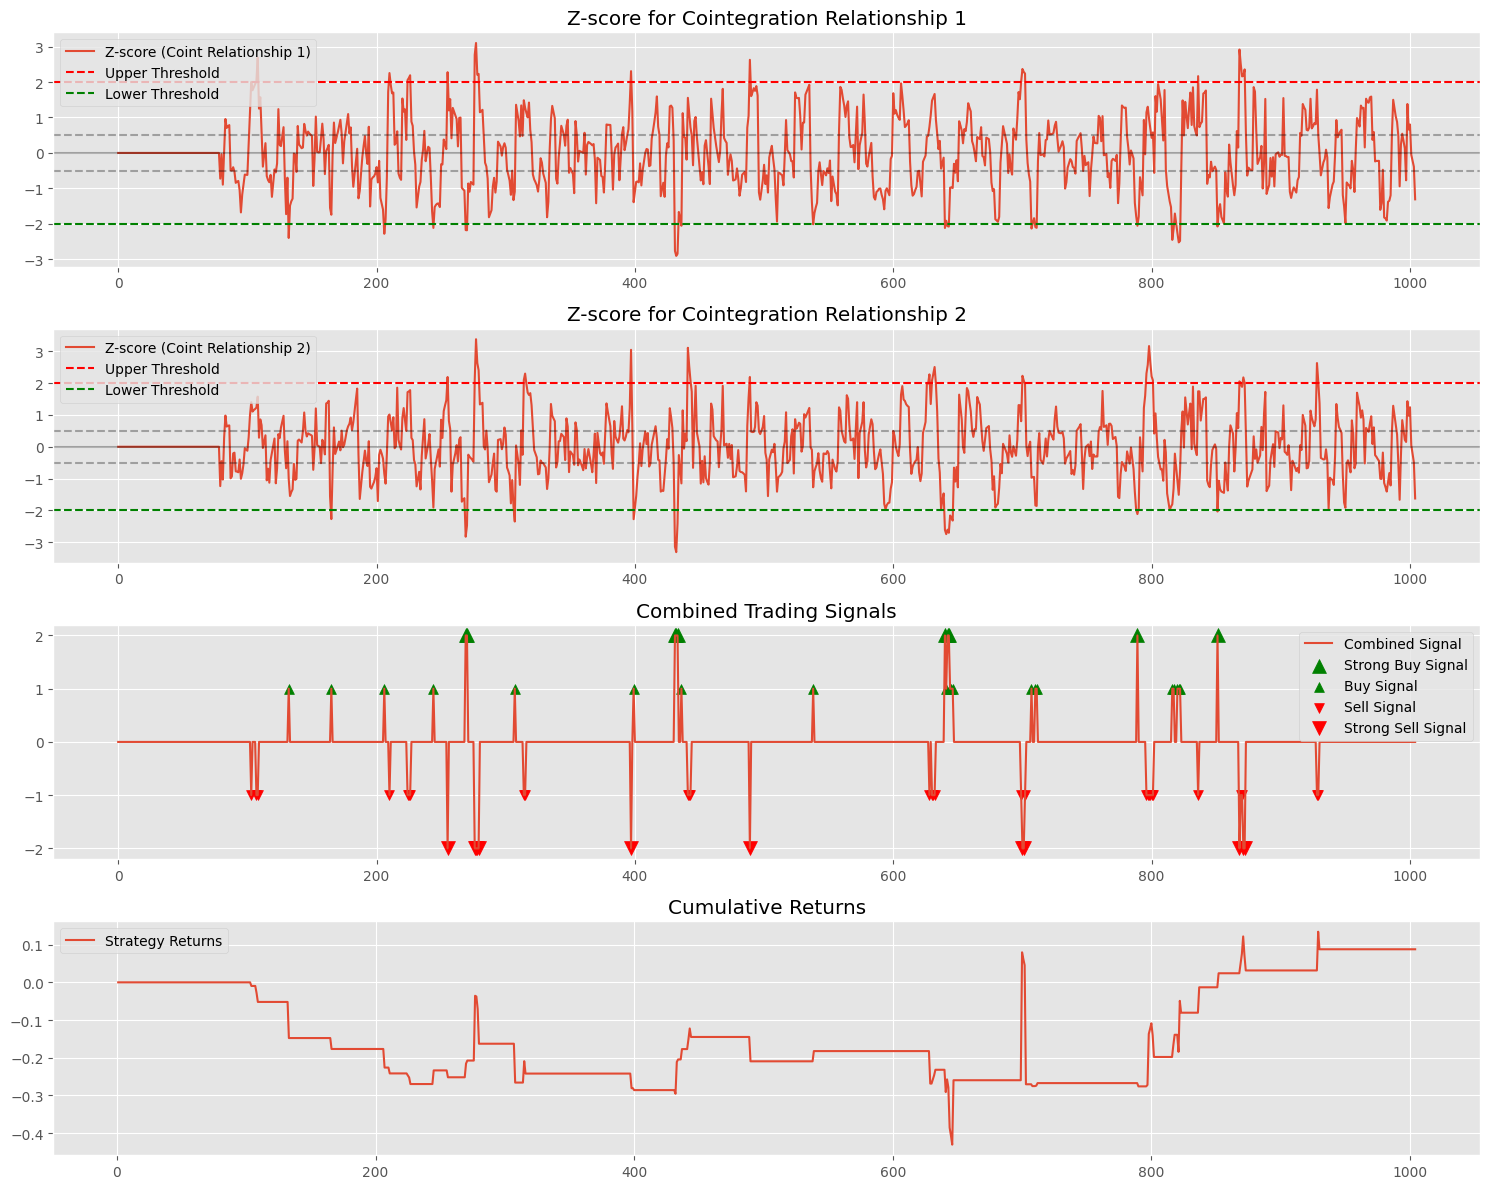

Annualized Return: 0.0993
Annualized Volatility: 0.4099
Sharpe Ratio: 0.2422
Maximum Drawdown: -0.4304
Win Rate: 0.4444
Number of Trades: 75


In [68]:
window = 80  # Rolling window for calculating mean and std (e.g., 30 days)
spreads_df['spread1_mean'] = spreads_df['spread1'].rolling(window=window).mean()
spreads_df['spread1_std'] = spreads_df['spread1'].rolling(window=window).std()
spreads_df['z_score1'] = (spreads_df['spread1'] - spreads_df['spread1_mean']) / spreads_df['spread1_std']

spreads_df['spread2_mean'] = spreads_df['spread2'].rolling(window=window).mean()
spreads_df['spread2_std'] = spreads_df['spread2'].rolling(window=window).std()
spreads_df['z_score2'] = (spreads_df['spread2'] - spreads_df['spread2_mean']) / spreads_df['spread2_std']

# Generate trading signals based on both z-scores
spreads_df['combined_signal'] = 0  # Initialize combined signals

# Define thresholds
entry_threshold = 2
exit_threshold = 0.5

# Both relationships suggest buy gold (strong signal)
spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
               (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 2

# Both relationships suggest sell gold (strong signal)
spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
               (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = -2

# Conflicting signals (no trade)
spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
               (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 0
spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
               (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = 0

# One relationship suggests buy (weak signal)
spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
               (abs(spreads_df['z_score2']) <= entry_threshold), 'combined_signal'] = 1
spreads_df.loc[(abs(spreads_df['z_score1']) <= entry_threshold) & 
               (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 1

# One relationship suggests sell (weak signal)
spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
               (abs(spreads_df['z_score2']) <= entry_threshold), 'combined_signal'] = -1
spreads_df.loc[(abs(spreads_df['z_score1']) <= entry_threshold) & 
               (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = -1

# Exit positions when both z-scores are near zero
spreads_df.loc[(abs(spreads_df['z_score1']) < exit_threshold) & 
               (abs(spreads_df['z_score2']) < exit_threshold), 'combined_signal'] = 0

# Calculate position changes (entry/exit points)
spreads_df['position_change'] = spreads_df['combined_signal'].diff()

# Implement a simple backtesting framework
# Extract gold and silver price columns
gold_col = 0  # Adjust based on the column index of gold in your data
silver_col = 1  # Adjust based on the column index of silver in your data

gold_prices = slv_gld_merged_aligned.iloc[:, gold_col]
silver_prices = slv_gld_merged_aligned.iloc[:, silver_col]

# Create a DataFrame to track our portfolio
portfolio = pd.DataFrame(index=spreads_df.index)
portfolio['gold_position'] = 0
portfolio['silver_position'] = 0
portfolio['cash'] = 10000  # Starting with $10,000

# Fill in the initial NaN values in spreads_df
spreads_df = spreads_df.fillna(0)

# Implement trading logic
for i in range(1, len(spreads_df)):
    # Get previous positions
    prev_gold_pos = portfolio.loc[portfolio.index[i-1], 'gold_position']
    prev_silver_pos = portfolio.loc[portfolio.index[i-1], 'silver_position']
    prev_cash = portfolio.loc[portfolio.index[i-1], 'cash']
    
    # Get current prices
    gold_price = gold_prices.iloc[i]
    silver_price = silver_prices.iloc[i]
    
    # Get current signal
    current_signal = spreads_df.loc[spreads_df.index[i], 'combined_signal']
    
    # Set base position size
    base_position_size = 1000  # Dollar amount per trade
    
    # Update positions based on combined signals
    if current_signal == 2 and prev_gold_pos == 0:  # Strong buy gold signal
        position_size = base_position_size * 1.5  # 50% larger position for strong signals
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = -silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        
    elif current_signal == 1 and prev_gold_pos == 0:  # Regular buy gold signal
        position_size = base_position_size
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = -silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        
    elif current_signal == -1 and prev_gold_pos == 0:  # Regular sell gold signal
        position_size = base_position_size
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = -gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        
    elif current_signal == -2 and prev_gold_pos == 0:  # Strong sell gold signal
        position_size = base_position_size * 1.5  # 50% larger position for strong signals
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = -gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        
    elif current_signal == 0 and (prev_gold_pos != 0 or prev_silver_pos != 0):  # Close positions
        # Calculate PnL
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = 0
        portfolio.loc[portfolio.index[i], 'silver_position'] = 0
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl
        
    else:  # Maintain positions
        # Update positions to account for price changes
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = prev_gold_pos
        portfolio.loc[portfolio.index[i], 'silver_position'] = prev_silver_pos
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl

# Calculate portfolio value
portfolio['gold_value'] = portfolio['gold_position'] * gold_prices
portfolio['silver_value'] = portfolio['silver_position'] * silver_prices
portfolio['total_value'] = portfolio['gold_value'] + portfolio['silver_value'] + portfolio['cash']

# Calculate returns
portfolio['returns'] = portfolio['total_value'].pct_change()
portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() - 1

# Visualize results
plt.figure(figsize=(15, 12))

# Plot 1: Z-scores for first cointegration relationship
plt.subplot(4, 1, 1)
plt.plot(spreads_df.index, spreads_df['z_score1'], label='Z-score (Coint Relationship 1)')
plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-entry_threshold, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.title('Z-score for Cointegration Relationship 1')
plt.legend()

# Plot 2: Z-scores for second cointegration relationship
plt.subplot(4, 1, 2)
plt.plot(spreads_df.index, spreads_df['z_score2'], label='Z-score (Coint Relationship 2)')
plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-entry_threshold, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.title('Z-score for Cointegration Relationship 2')
plt.legend()

# Plot 3: Trading signals
plt.subplot(4, 1, 3)
plt.plot(spreads_df.index, spreads_df['combined_signal'], label='Combined Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == 2], 
            [2] * sum(spreads_df['combined_signal'] == 2), 
            marker='^', color='g', s=100, label='Strong Buy Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == 1], 
            [1] * sum(spreads_df['combined_signal'] == 1), 
            marker='^', color='g', s=50, label='Buy Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == -1], 
            [-1] * sum(spreads_df['combined_signal'] == -1), 
            marker='v', color='r', s=50, label='Sell Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == -2], 
            [-2] * sum(spreads_df['combined_signal'] == -2), 
            marker='v', color='r', s=100, label='Strong Sell Signal')
plt.title('Combined Trading Signals')
plt.legend()

# Plot 4: Cumulative returns
plt.subplot(4, 1, 4)
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Strategy Returns')
plt.title('Cumulative Returns')
plt.legend()

plt.tight_layout()
plt.show()

# Performance metrics
annualized_return = portfolio['returns'].mean() * 252  # Assuming 252 trading days
annualized_vol = portfolio['returns'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else 0
max_drawdown = (portfolio['total_value'] / portfolio['total_value'].cummax() - 1).min()
win_rate = sum(portfolio['returns'] > 0) / sum(portfolio['returns'] != 0) if sum(portfolio['returns'] != 0) > 0 else 0

print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Number of Trades: {sum(spreads_df['position_change'] != 0)}")

Cointegration Relationship 1: Gold adjusts 12.33%, Silver adjusts 87.67%
Cointegration Relationship 2: Gold adjusts 12.23%, Silver adjusts 87.77%
Expected mean reversion time for gold: 14.3 days


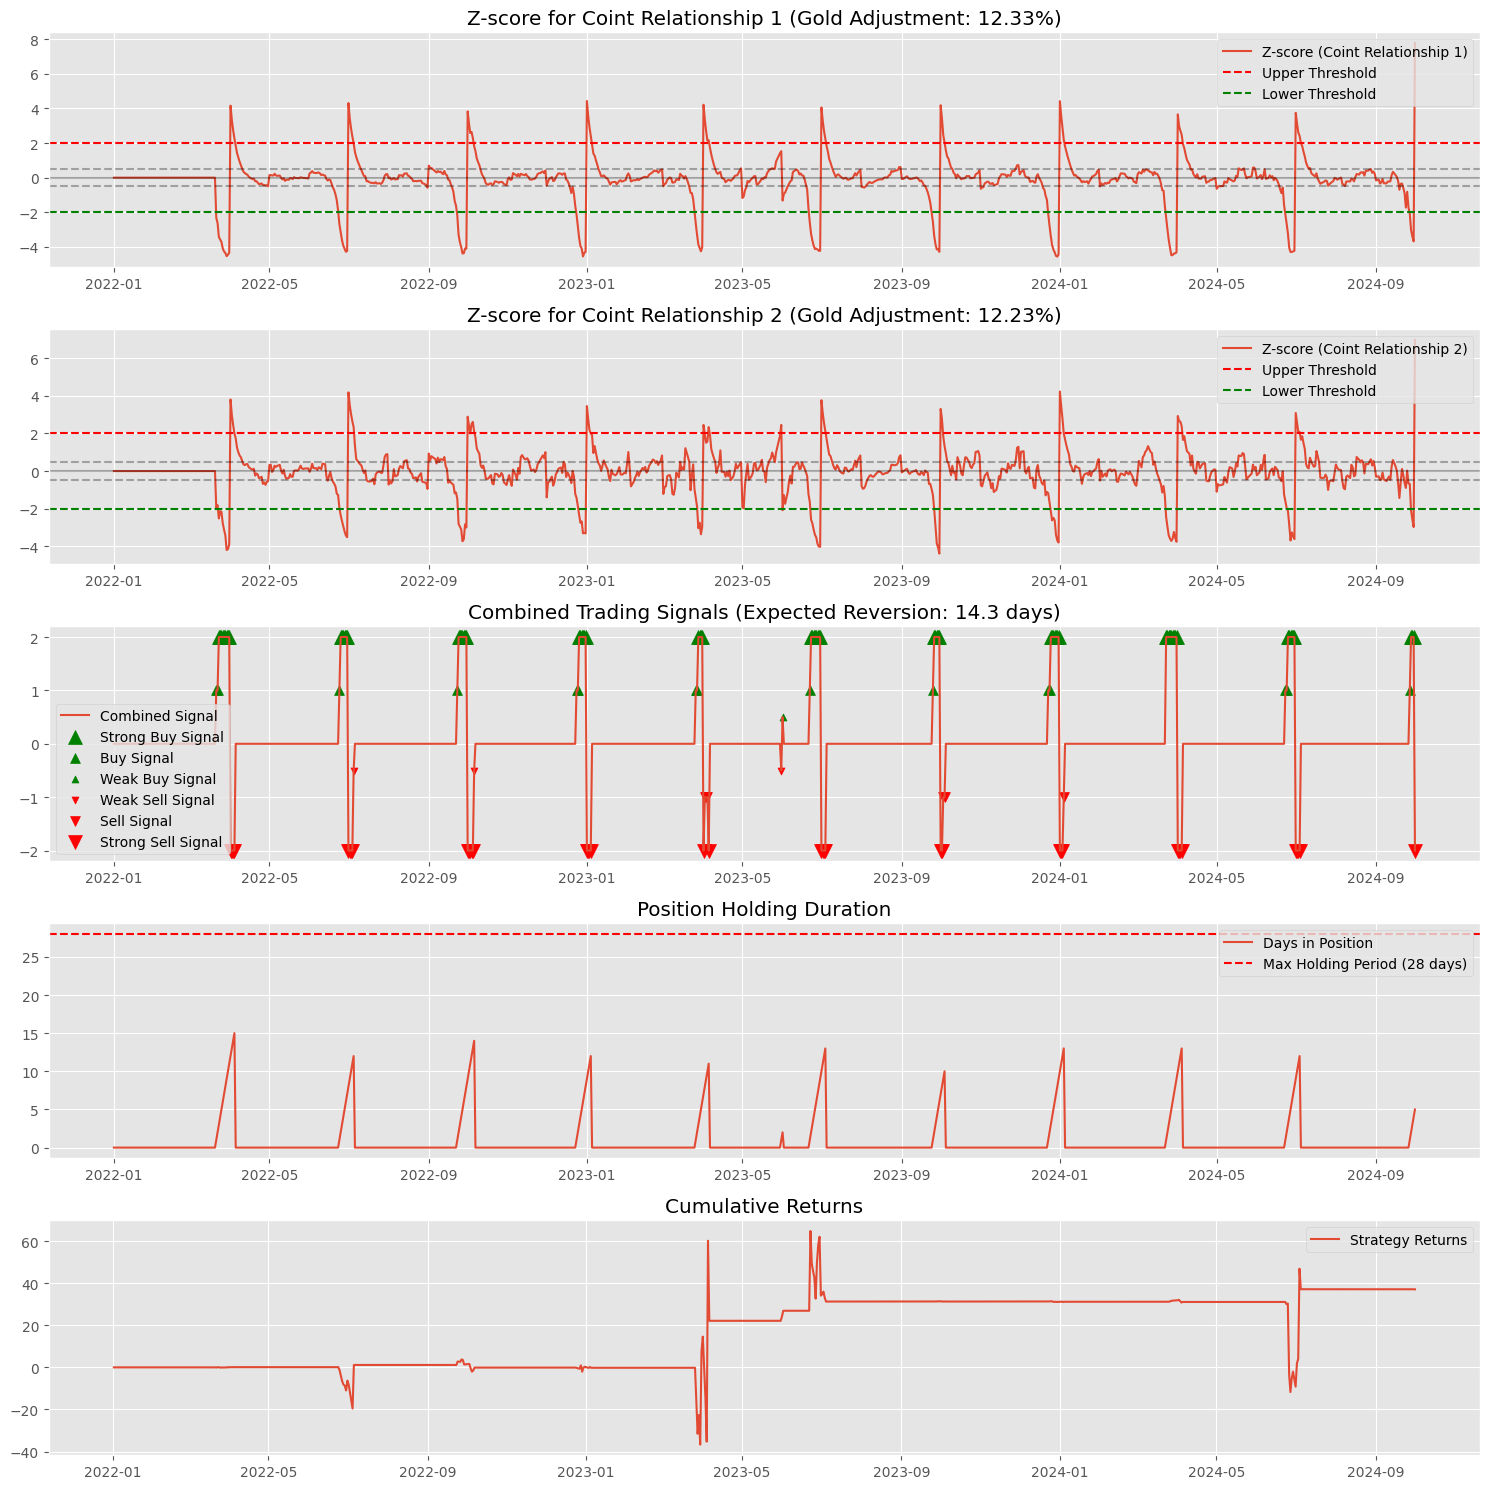

Annualized Return: -5.1523
Annualized Volatility: 14.2529
Sharpe Ratio: -0.3615
Maximum Drawdown: -17.8235
Win Rate: 0.5227
Number of Trades: 51
Average Holding Period: 6.60 days
Max Allowed Holding Period: 28 days


In [162]:
window = 80  # Rolling window for calculating mean and std
spreads_df['spread1_mean'] = spreads_df['spread1'].rolling(window=window).mean()
spreads_df['spread1_std'] = spreads_df['spread1'].rolling(window=window).std()
spreads_df['z_score1'] = (spreads_df['spread1'] - spreads_df['spread1_mean']) / spreads_df['spread1_std']

spreads_df['spread2_mean'] = spreads_df['spread2'].rolling(window=window).mean()
spreads_df['spread2_std'] = spreads_df['spread2'].rolling(window=window).std()
spreads_df['z_score2'] = (spreads_df['spread2'] - spreads_df['spread2_mean']) / spreads_df['spread2_std']

# Get adjustment speeds from alpha matrix
# Assuming first variable is gold, second is silver
gold_adjustment_speed1 = abs(alpha[gold_col, 0])
gold_adjustment_speed2 = abs(alpha[gold_col, 1])
silver_adjustment_speed1 = abs(alpha[silver_col, 0])
silver_adjustment_speed2 = abs(alpha[silver_col, 1])

# Calculate adjustment ratios (which series adjusts faster to restore equilibrium)
adjustment_ratio1 = gold_adjustment_speed1 / (gold_adjustment_speed1 + silver_adjustment_speed1)
adjustment_ratio2 = gold_adjustment_speed2 / (gold_adjustment_speed2 + silver_adjustment_speed2)

print(f"Cointegration Relationship 1: Gold adjusts {adjustment_ratio1:.2%}, Silver adjusts {1-adjustment_ratio1:.2%}")
print(f"Cointegration Relationship 2: Gold adjusts {adjustment_ratio2:.2%}, Silver adjusts {1-adjustment_ratio2:.2%}")


# Generate trading signals based on both z-scores and adjustment speeds
spreads_df['combined_signal'] = 0  # Initialize combined signals

# Define thresholds
entry_threshold = 2
exit_threshold = 0.5

# Both relationships suggest buy gold (strong signal)
spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
               (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 2

# Both relationships suggest sell gold (strong signal)
spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
               (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = -2

# Conflicting signals (no trade)
spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
               (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 0
spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
               (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = 0

# One relationship suggests buy (weak signal)
# Weight the signal based on which relationship has faster adjustment
if adjustment_ratio1 > adjustment_ratio2:  # Relationship 1 adjusts faster for gold
    # Prioritize relationship 1
    spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
                   (abs(spreads_df['z_score2']) <= entry_threshold), 'combined_signal'] = 1
    
    # Give less weight to relationship 2
    spreads_df.loc[(abs(spreads_df['z_score1']) <= entry_threshold) & 
                   (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 0.5
else:  # Relationship 2 adjusts faster for gold
    # Give less weight to relationship 1
    spreads_df.loc[(spreads_df['z_score1'] < -entry_threshold) & 
                   (abs(spreads_df['z_score2']) <= entry_threshold), 'combined_signal'] = 0.5
    
    # Prioritize relationship 2
    spreads_df.loc[(abs(spreads_df['z_score1']) <= entry_threshold) & 
                   (spreads_df['z_score2'] < -entry_threshold), 'combined_signal'] = 1

# One relationship suggests sell (weak signal)
# Weight the signal based on which relationship has faster adjustment
if adjustment_ratio1 > adjustment_ratio2:  # Relationship 1 adjusts faster for gold
    # Prioritize relationship 1
    spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
                   (abs(spreads_df['z_score2']) <= entry_threshold), 'combined_signal'] = -1
    
    # Give less weight to relationship 2
    spreads_df.loc[(abs(spreads_df['z_score1']) <= entry_threshold) & 
                   (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = -0.5
else:  # Relationship 2 adjusts faster for gold
    # Give less weight to relationship 1
    spreads_df.loc[(spreads_df['z_score1'] > entry_threshold) & 
                   (abs(spreads_df['z_score2']) <= entry_threshold), 'combined_signal'] = -0.5
    
    # Prioritize relationship 2
    spreads_df.loc[(abs(spreads_df['z_score1']) <= entry_threshold) & 
                   (spreads_df['z_score2'] > entry_threshold), 'combined_signal'] = -1

# Exit positions when both z-scores are near zero
spreads_df.loc[(abs(spreads_df['z_score1']) < exit_threshold) & 
               (abs(spreads_df['z_score2']) < exit_threshold), 'combined_signal'] = 0

# Calculate expected mean reversion time based on adjustment speeds
# Useful for setting holding period expectations
if adjustment_ratio1 > adjustment_ratio2:
    primary_gold_adjustment = gold_adjustment_speed1
else:
    primary_gold_adjustment = gold_adjustment_speed2
    
expected_reversion_days = 1 / primary_gold_adjustment
print(f"Expected mean reversion time for gold: {expected_reversion_days:.1f} days")

# Calculate position changes (entry/exit points)
spreads_df['position_change'] = spreads_df['combined_signal'].diff()

# Implement a simple backtesting framework
# Extract gold and silver price columns
gold_col = 0  # Adjust based on the column index of gold in your data
silver_col = 1  # Adjust based on the column index of silver in your data

gold_prices = slv_gld_merged.iloc[:, gold_col]
silver_prices = slv_gld_merged.iloc[:, silver_col]

# Create a DataFrame to track our portfolio
portfolio = pd.DataFrame(index=spreads_df.index)
portfolio['gold_position'] = 0
portfolio['silver_position'] = 0
portfolio['cash'] = 10000  # Starting with $10,000
portfolio['days_in_position'] = 0

# Fill in the initial NaN values in spreads_df
spreads_df = spreads_df.fillna(0)

# Base position size
base_position_size = 1000  # Dollar amount per trade

# Maximum position holding time (based on adjustment speed)
max_holding_days = int(2 * expected_reversion_days)  # 2x the expected reversion time

# Implement trading logic
for i in range(1, len(spreads_df)):
    # Get previous positions
    prev_gold_pos = portfolio.loc[portfolio.index[i-1], 'gold_position']
    prev_silver_pos = portfolio.loc[portfolio.index[i-1], 'silver_position']
    prev_cash = portfolio.loc[portfolio.index[i-1], 'cash']
    prev_days_in_position = portfolio.loc[portfolio.index[i-1], 'days_in_position']
    
    # Get current prices
    gold_price = gold_prices.iloc[i]
    silver_price = silver_prices.iloc[i]
    
    # Get current signal
    current_signal = spreads_df.loc[spreads_df.index[i], 'combined_signal']
    
    # Check if we've held the position too long (based on adjustment speed)
    if prev_days_in_position >= max_holding_days and (prev_gold_pos != 0 or prev_silver_pos != 0):
        # Force close position
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = 0
        portfolio.loc[portfolio.index[i], 'silver_position'] = 0
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 0
        continue
    
    # Update positions based on combined signals
    if current_signal == 2 and prev_gold_pos == 0:  # Strong buy gold signal
        position_size = base_position_size * 1.5  # 50% larger position for strong signals
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = -silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 1
        
    elif current_signal == 1 and prev_gold_pos == 0:  # Regular buy gold signal
        position_size = base_position_size
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = -silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 1
        
    elif current_signal == 0.5 and prev_gold_pos == 0:  # Weak buy gold signal
        position_size = base_position_size * 0.5  # 50% smaller position for weak signals
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = -silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 1
        
    elif current_signal == -0.5 and prev_gold_pos == 0:  # Weak sell gold signal
        position_size = base_position_size * 0.5  # 50% smaller position for weak signals
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = -gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 1
        
    elif current_signal == -1 and prev_gold_pos == 0:  # Regular sell gold signal
        position_size = base_position_size
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = -gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 1
        
    elif current_signal == -2 and prev_gold_pos == 0:  # Strong sell gold signal
        position_size = base_position_size * 1.5  # 50% larger position for strong signals
        gold_units = position_size / gold_price
        silver_units = position_size / silver_price
        portfolio.loc[portfolio.index[i], 'gold_position'] = -gold_units
        portfolio.loc[portfolio.index[i], 'silver_position'] = silver_units
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 1
        
    elif current_signal == 0 and (prev_gold_pos != 0 or prev_silver_pos != 0):  # Close positions
        # Calculate PnL
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = 0
        portfolio.loc[portfolio.index[i], 'silver_position'] = 0
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl
        portfolio.loc[portfolio.index[i], 'days_in_position'] = 0
        
    else:  # Maintain positions
        # Update positions to account for price changes
        gold_pnl = prev_gold_pos * (gold_price - gold_prices.iloc[i-1])
        silver_pnl = prev_silver_pos * (silver_price - silver_prices.iloc[i-1])
        portfolio.loc[portfolio.index[i], 'gold_position'] = prev_gold_pos
        portfolio.loc[portfolio.index[i], 'silver_position'] = prev_silver_pos
        portfolio.loc[portfolio.index[i], 'cash'] = prev_cash + gold_pnl + silver_pnl
        
        # Increment days in position if we have a position
        if prev_gold_pos != 0 or prev_silver_pos != 0:
            portfolio.loc[portfolio.index[i], 'days_in_position'] = prev_days_in_position + 1
        else:
            portfolio.loc[portfolio.index[i], 'days_in_position'] = 0

# Calculate portfolio value
portfolio['gold_value'] = portfolio['gold_position'] * gold_prices
portfolio['silver_value'] = portfolio['silver_position'] * silver_prices
portfolio['total_value'] = portfolio['gold_value'] + portfolio['silver_value'] + portfolio['cash']

# Calculate returns
portfolio['returns'] = portfolio['total_value'].pct_change()
portfolio['cumulative_returns'] = (1 + portfolio['returns']).cumprod() - 1

# Visualize results
plt.figure(figsize=(15, 15))

# Plot 1: Z-scores for first cointegration relationship
plt.subplot(5, 1, 1)
plt.plot(spreads_df.index, spreads_df['z_score1'], label='Z-score (Coint Relationship 1)')
plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-entry_threshold, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.title(f'Z-score for Coint Relationship 1 (Gold Adjustment: {adjustment_ratio1:.2%})')
plt.legend()

# Plot 2: Z-scores for second cointegration relationship
plt.subplot(5, 1, 2)
plt.plot(spreads_df.index, spreads_df['z_score2'], label='Z-score (Coint Relationship 2)')
plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-entry_threshold, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=-exit_threshold, color='k', linestyle='--', alpha=0.3)
plt.title(f'Z-score for Coint Relationship 2 (Gold Adjustment: {adjustment_ratio2:.2%})')
plt.legend()

# Plot 3: Trading signals
plt.subplot(5, 1, 3)
plt.plot(spreads_df.index, spreads_df['combined_signal'], label='Combined Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == 2], 
            [2] * sum(spreads_df['combined_signal'] == 2), 
            marker='^', color='g', s=100, label='Strong Buy Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == 1], 
            [1] * sum(spreads_df['combined_signal'] == 1), 
            marker='^', color='g', s=50, label='Buy Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == 0.5], 
            [0.5] * sum(spreads_df['combined_signal'] == 0.5), 
            marker='^', color='g', s=25, label='Weak Buy Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == -0.5], 
            [-0.5] * sum(spreads_df['combined_signal'] == -0.5), 
            marker='v', color='r', s=25, label='Weak Sell Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == -1], 
            [-1] * sum(spreads_df['combined_signal'] == -1), 
            marker='v', color='r', s=50, label='Sell Signal')
plt.scatter(spreads_df.index[spreads_df['combined_signal'] == -2], 
            [-2] * sum(spreads_df['combined_signal'] == -2), 
            marker='v', color='r', s=100, label='Strong Sell Signal')
plt.title(f'Combined Trading Signals (Expected Reversion: {expected_reversion_days:.1f} days)')
plt.legend()

# Plot 4: Position holding time
plt.subplot(5, 1, 4)
plt.plot(portfolio.index, portfolio['days_in_position'], label='Days in Position')
plt.axhline(y=max_holding_days, color='r', linestyle='--', label=f'Max Holding Period ({max_holding_days} days)')
plt.title('Position Holding Duration')
plt.legend()

# Plot 5: Cumulative returns
plt.subplot(5, 1, 5)
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Strategy Returns')
plt.title('Cumulative Returns')
plt.legend()

plt.tight_layout()
plt.show()

# Performance metrics
annualized_return = portfolio['returns'].mean() * 252  # Assuming 252 trading days
annualized_vol = portfolio['returns'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else 0
max_drawdown = (portfolio['total_value'] / portfolio['total_value'].cummax() - 1).min()
win_rate = sum(portfolio['returns'] > 0) / sum(portfolio['returns'] != 0) if sum(portfolio['returns'] != 0) > 0 else 0
avg_holding_period = portfolio.loc[portfolio['days_in_position'] > 0, 'days_in_position'].mean()

print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Win Rate: {win_rate:.4f}")
print(f"Number of Trades: {sum(spreads_df['position_change'] != 0)}")
print(f"Average Holding Period: {avg_holding_period:.2f} days")
print(f"Max Allowed Holding Period: {max_holding_days} days")